In [1]:
import filterpy
from numpy.random import randn
import matplotlib.pyplot as plt
import numpy as np

filterpy.__version__

# CODE SOURCE: https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/04b2bea802321086effbd99402fc13c893d11110/08-Designing-Kalman-Filters.ipynb

'1.4.5'

## Example Testing Kalman Filter

In [2]:
class PosSensor(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        self.truth_pos = []
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        self.truth_pos.append((self.pos[0], self.pos[1]))
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

50
50


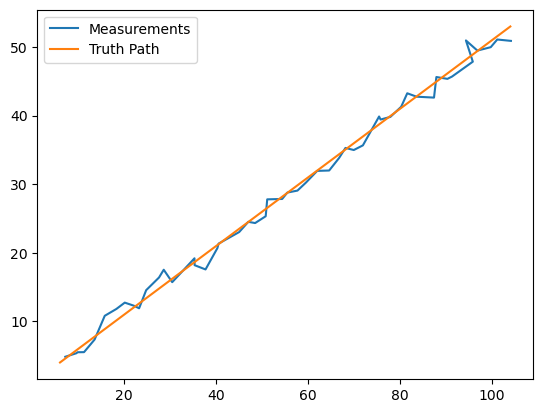

In [3]:
pos, vel = (4, 3), (2, 1)
sensor = PosSensor(pos, vel, noise_std=1)
ps = np.array([sensor.read() for _ in range(50)])
x_truth, y_truth = zip(*sensor.truth_pos)
plt.plot(ps[:, 0], ps[:, 1], label="Measurements")
plt.plot(x_truth, y_truth, label="Truth Path")
plt.legend()

print(len(x_truth))
print(len(ps[:, 0]))

In [4]:
def calculate_acc_err_2D(x_truth_in, y_truth_in, x_pred, y_pred, x_meas, y_meas):
    avg_filter_error = np.mean(np.sqrt((np.array(x_truth_in) - np.array(x_pred)) ** 2 + (np.array(y_truth_in) - np.array(y_pred)) ** 2))
    avg_meas_error = np.mean(np.sqrt((np.array(x_truth_in) - np.array(x_meas)) ** 2 + (np.array(y_truth_in) - np.array(y_meas)) ** 2))
    
    print(f"Average Filter Error [m]: {avg_filter_error}")
    print(f"Average Measurement Error [m]: {avg_meas_error}")
    return avg_filter_error, avg_meas_error

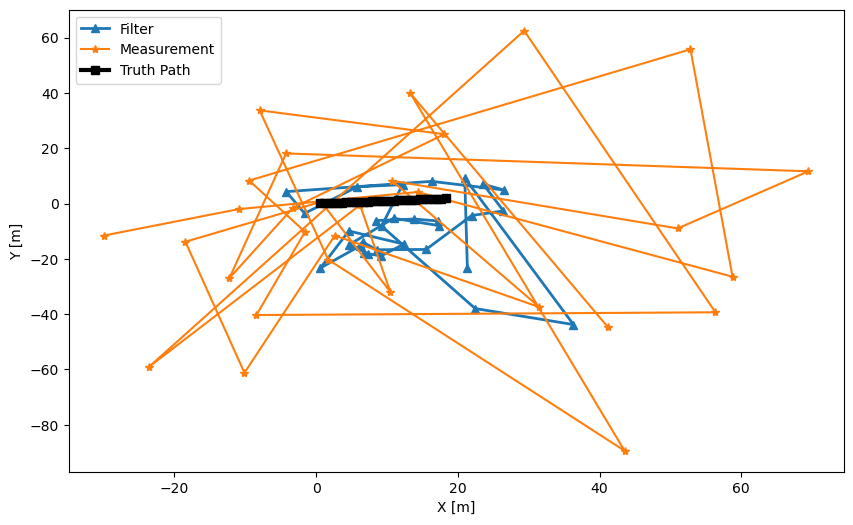

30


In [5]:
from filterpy.stats import plot_covariance
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from scipy.linalg import block_diag

R_std = 100
Q_std = R_std/1000

def tracker1():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.0   # time step

    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1/0.3048, 0, 0, 0],
                          [0, 0, 1/0.3048, 0]])

    tracker.R = np.eye(2) * R_std**2
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0]]).T
    tracker.P = np.eye(4) * 500.
    return tracker

# simulate robot movement
N = 30
sensor = PosSensor((0, 0), (2, .2), noise_std=R_std)
zs = np.array([sensor.read() for _ in range(N)])
x_truth, y_truth = zip(*sensor.truth_pos)

#run filter
robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)
plt.figure(figsize=(10, 6))
for x, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
    #plot_covariance(mean, cov=cov, fc='g', std=3, alpha=0.5)
    
#plot results
zs *= .3048 # convert to meters
x_truth = tuple(x * 0.3048 for x in x_truth)
y_truth = tuple(y * 0.3048 for y in y_truth)

plt.plot(mu[:, 0], mu[:, 2], label='Filter', linestyle='-', marker='^', linewidth=2)
plt.plot(zs[:, 0], zs[:, 1], label='Measurement', marker='*')
plt.plot(x_truth, y_truth, label="Truth Path", marker='s', color='k', linewidth=3)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.legend(loc=2)
plt.show()

print(len(x_truth))

In [6]:
calculate_acc_err_2D(x_truth, y_truth, mu[:, 0], mu[:, 2], zs[:, 0], zs[:, 1])

Average Filter Error [m]: 17.240871084952655
Average Measurement Error [m]: 38.39653338769791


(17.240871084952655, 38.39653338769791)

## KF Application

In [7]:
import helper.training_preprocess as tp
from collections import defaultdict

In [8]:
def calculate_acc_err_3D(x_truth_in, y_truth_in, z_truth_in, x_pred, y_pred, z_pred, x_meas, y_meas, z_meas):
    avg_filter_error = np.mean(np.sqrt((np.array(x_truth_in) - np.array(x_pred)) ** 2 + (np.array(y_truth_in) - np.array(y_pred)) ** 2) + (np.array(z_truth_in) - np.array(z_pred)) ** 2)
    avg_meas_error = np.mean(np.sqrt((np.array(x_truth_in) - np.array(x_meas)) ** 2 + (np.array(y_truth_in) - np.array(y_meas)) ** 2) + (np.array(z_truth_in) - np.array(z_meas)) ** 2)
    
    print(f"Average Filter Error [m]: {avg_filter_error}")
    print(f"Average Measurement Error [m]: {avg_meas_error}")
    return avg_filter_error, avg_meas_error

In [9]:
sigma_data = 10
train_df, test_df, train_traj_data, test_traj_data = tp.readin_dataframes(train_split=0.9, sensor_pos_uncer=sigma_data)

Number of Train Trajectories: 4584
Number of Test Trajectories: 509


In [10]:
# train_df.to_csv(f"../../dataset/dataframe-readins/train/{sigma_data}-sigma-raw.csv", index=False)
# test_df.to_csv(f"../../dataset/dataframe-readins/test/{sigma_data}-sigma-raw", index=False)

In [11]:
def tracker_test(test_df_in):
    Q_std = 1e-6
    dt = test_df_in.timestamp[1] - test_df_in.timestamp[0]  # time step
    pos_std = test_df_in.sigma_pos[0]
    vel_std = test_df_in.sigma_vel[0]
    
    tracker = KalmanFilter(dim_x=6, dim_z=6)
    
    tracker.F = np.array([[1, 0, 0, dt, 0, 0],
                          [0, 1, 0, 0, dt, 0],
                          [0, 0, 1, 0, 0, dt],
                          [0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 1]])
    tracker.u = 0.
    tracker.H = np.eye(6)
    tracker.R = np.eye(6)
    diag_indices = np.diag_indices(6)
    tracker.R [diag_indices] = np.where(diag_indices[0] < 3, pos_std**2, vel_std**2)
    
    q = Q_discrete_white_noise(dim=3, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0, 0, 0]]).T
    tracker.P = np.eye(6) * 500.
    return tracker

### SINGLE TRAJ TESTING

In [12]:
test_traj_df = test_traj_data[1]
display(test_traj_df)

,timestamp,tx,ty,tz,vx,vy,vz,tx_measured,ty_measured,tz_measured,vx_measured,vy_measured,vz_measured,sigma_pos,sigma_vel,tx_measured_plus,ty_measured_plus,tz_measured_plus,delta_time
0,0.000000,-40.805557,-7.557310,16.847527,-3.592263,0.964076,0.089414,-29.325424,-5.980366,10.906606,-3.587588,0.946853,0.080609,10,0.01,-53.148352,-15.075849,-9.132545,0.100000
1,0.100000,-41.164783,-7.460903,16.856468,-2.761677,0.770851,0.190097,-53.148352,-15.075849,-9.132545,-2.770135,0.771154,0.189428,10,0.01,-34.879743,2.963538,5.794444,0.100000
2,0.200000,-41.440951,-7.383818,16.875478,-2.402171,0.680947,0.580820,-34.879743,2.963538,5.794444,-2.402677,0.674142,0.588837,10,0.01,-63.308977,-13.110081,30.881801,0.100000
3,0.300000,-41.681167,-7.315723,16.933560,-1.839856,0.252255,1.005508,-63.308977,-13.110081,30.881801,-1.843454,0.257806,1.020196,10,0.01,-38.379140,-8.899590,7.451632,0.100000
4,0.399999,-41.865152,-7.290498,17.034110,-1.630406,-0.376203,1.386813,-38.379140,-8.899590,7.451632,-1.623985,-0.387016,1.374551,10,0.01,-58.375861,-17.814933,18.573853,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,12.799988,-42.201681,-8.045901,17.218663,0.866835,1.912802,-1.044842,-28.222620,-8.370077,17.104295,0.871407,1.901006,-1.030006,10,0.01,-52.931448,-30.876466,5.788579,0.100000
129,12.899988,-42.114997,-7.854620,17.114178,1.081704,1.962632,-1.225824,-52.931448,-30.876466,5.788579,1.081275,1.954673,-1.222236,10,0.01,-57.119168,7.883637,24.432325,0.099999
130,12.999988,-42.006827,-7.658358,16.991596,1.118989,1.663125,-1.125835,-57.119168,7.883637,24.432325,1.100944,1.661742,-1.116002,10,0.01,-36.088518,-3.888981,15.314003,0.099999
131,13.099987,-41.894929,-7.492046,16.879013,1.337829,1.676547,-1.233700,-36.088518,-3.888981,15.314003,1.340424,1.668521,-1.241152,10,0.01,-37.040926,-28.038845,25.289515,0.100000


In [13]:
# grab measurements
measurement_cols = ['tx_measured', 'ty_measured', 'tz_measured', 'vx_measured', 'vy_measured', 'vz_measured']
truth_cols = ['tx', 'ty', 'tz', 'vx', 'vy', 'vz']
              
measurements = test_traj_df[measurement_cols].to_numpy()
truth = test_traj_df[truth_cols].to_numpy()

In [14]:
# filtering
drone_tracker = tracker_test(test_traj_df)
mu, cov, _, _ = drone_tracker.batch_filter(measurements)

In [15]:
x_uncer = np.sqrt(cov[:, 0, 0])
y_uncer = np.sqrt(cov[:, 1, 1])
z_uncer = np.sqrt(cov[:, 2, 2])

print(f"Avg X STD: {np.mean(x_uncer)}")
print(f"Avg Y STD: {np.mean(y_uncer)}")
print(f"Avg Z STD: {np.mean(z_uncer)}")

print(x_uncer.shape)

Avg X STD: 1.6106740020562809
Avg Y STD: 1.610674002056614
Avg Z STD: 1.6106740020895625
(133,)


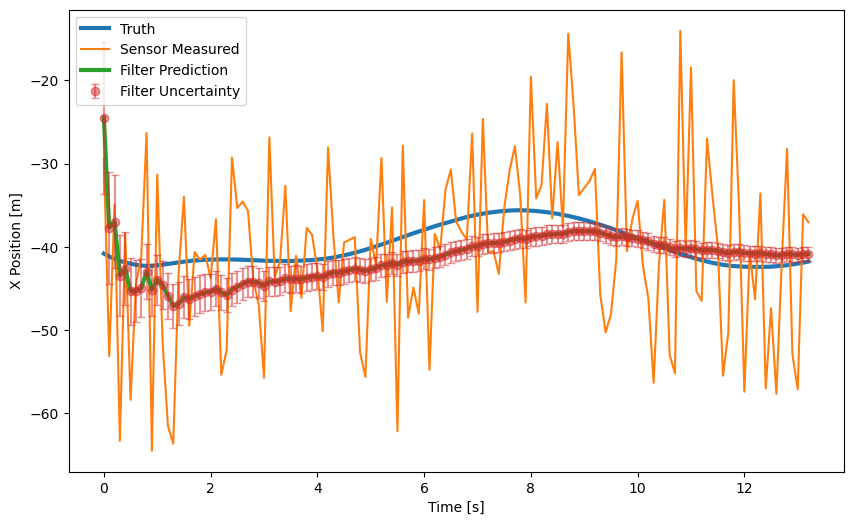

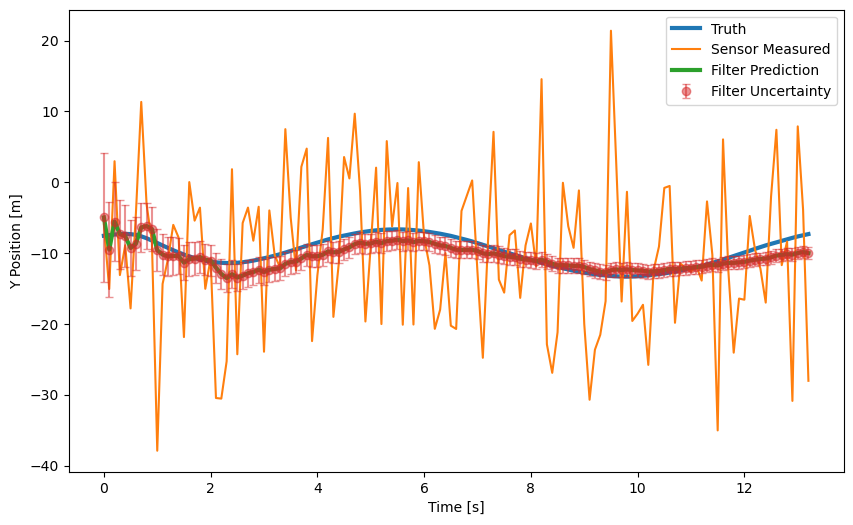

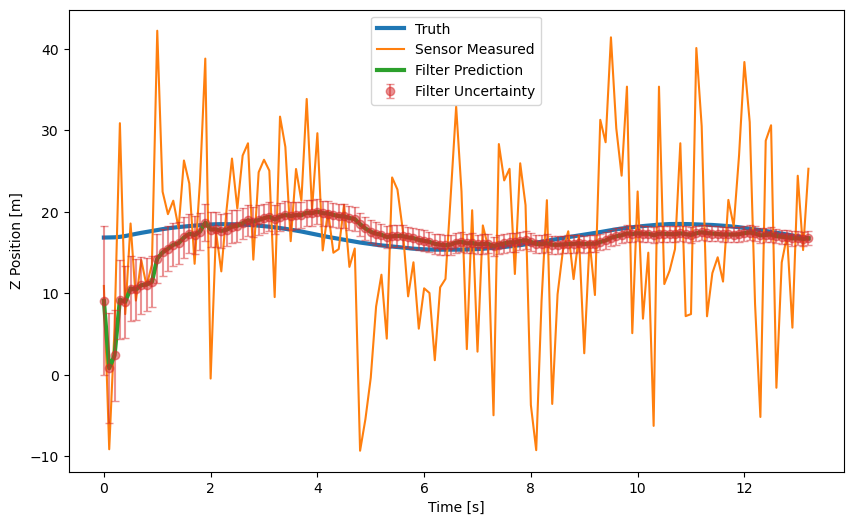

In [16]:
# plotting
plt.figure(figsize=(10,6))
plt.plot(test_traj_df.timestamp[:], truth[:, 0], label='Truth', linewidth=3)
plt.plot(test_traj_df.timestamp[:], measurements[:, 0], label='Sensor Measured')
plt.plot(test_traj_df.timestamp[:], mu[:, 0], label='Filter Prediction', linewidth=3)
plt.errorbar(test_traj_df.timestamp[:], mu[:, 0].squeeze(), yerr=x_uncer, fmt='o', alpha=0.5, label="Filter Uncertainty", capsize=3)
plt.xlabel("Time [s]")
plt.ylabel("X Position [m]")
plt.legend()

plt.figure(figsize=(10,6))
plt.plot(test_traj_df.timestamp[:], truth[:, 1], label='Truth', linewidth=3)
plt.plot(test_traj_df.timestamp[:], measurements[:, 1], label='Sensor Measured')
plt.plot(test_traj_df.timestamp[:], mu[:, 1], label='Filter Prediction', linewidth=3)
plt.errorbar(test_traj_df.timestamp[:], mu[:, 1].squeeze(), yerr=y_uncer, fmt='o', alpha=0.5, label="Filter Uncertainty", capsize=3)
plt.xlabel("Time [s]")
plt.ylabel("Y Position [m]")
plt.legend()

plt.figure(figsize=(10,6))
plt.plot(test_traj_df.timestamp[:], truth[:, 2], label='Truth', linewidth=3)
plt.plot(test_traj_df.timestamp[:], measurements[:, 2], label='Sensor Measured')
plt.plot(test_traj_df.timestamp[:], mu[:, 2], label='Filter Prediction', linewidth=3)
plt.errorbar(test_traj_df.timestamp[:], mu[:, 2].squeeze(), yerr=z_uncer, fmt='o', alpha=0.5, label="Filter Uncertainty", capsize=3)
plt.xlabel("Time [s]")
plt.ylabel("Z Position [m]")
plt.legend()

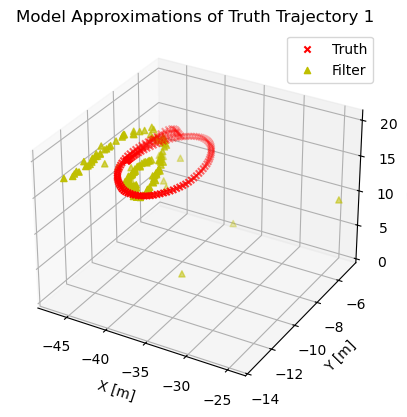

In [17]:
# 3D
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(truth[:, 0], truth[:, 1], truth[:, 2], c='r', marker='x', label="Truth")
ax.scatter(mu[:, 0], mu[:, 1], mu[:, 2], c='y', marker='^', label="Filter")


ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

ax.set_title(f'Model Approximations of Truth Trajectory {1}')
ax.legend()
plt.show()

In [18]:
calculate_acc_err_3D(truth[:, 0], truth[:, 1], truth[:, 2], mu[:, 0], mu[:, 1], mu[:, 2], measurements[:, 0], measurements[:, 1], measurements[:, 2])

Average Filter Error [m]: 13.388499111070807
Average Measurement Error [m]: 132.19349381705166


(13.388499111070807, 132.19349381705166)

### BATCH EVALUATION

In [19]:
%%time
filter_errs = []
filter_unc = defaultdict(list)
measurement_cols = ['tx_measured', 'ty_measured', 'tz_measured', 'vx_measured', 'vy_measured', 'vz_measured']
truth_cols = ['tx', 'ty', 'tz', 'vx', 'vy', 'vz']
for traj_no, traj_data in test_traj_data.items():
    measurements = traj_data[measurement_cols].to_numpy()
    truth = traj_data[truth_cols].to_numpy()
    
    drone_tracker = tracker_test(traj_data)
    mu, cov, _, _ = drone_tracker.batch_filter(measurements)

    kf_err, meas_err = calculate_acc_err_3D(truth[:, 0], truth[:, 1], truth[:, 2], mu[:, 0], mu[:, 1], mu[:, 2], measurements[:, 0], measurements[:, 1], measurements[:, 2])
    filter_errs.append(kf_err)
    filter_unc['x'].append(np.mean(np.sqrt(cov[:, 0, 0])))
    filter_unc['y'].append(np.mean(np.sqrt(cov[:, 1, 1])))
    filter_unc['z'].append(np.mean(np.sqrt(cov[:, 2, 2])))

Average Filter Error [m]: 13.388499111070807
Average Measurement Error [m]: 132.19349381705166
Average Filter Error [m]: 10.042703588437288
Average Measurement Error [m]: 117.80033093920271
Average Filter Error [m]: 6.226321641690516
Average Measurement Error [m]: 100.24493578081068
Average Filter Error [m]: 17.359199351976642
Average Measurement Error [m]: 110.57957309381052
Average Filter Error [m]: 9.781996781153115
Average Measurement Error [m]: 128.0478583644118
Average Filter Error [m]: 9.90905078097281
Average Measurement Error [m]: 114.34409138394489
Average Filter Error [m]: 12.180859859920673
Average Measurement Error [m]: 95.55834308681797
Average Filter Error [m]: 5.9983991544106825
Average Measurement Error [m]: 113.41271077560246
Average Filter Error [m]: 4.882296526252987
Average Measurement Error [m]: 127.05618734446924
Average Filter Error [m]: 7.296532653096013
Average Measurement Error [m]: 109.89434838531582
Average Filter Error [m]: 15.305253934705883
Average Measu

In [20]:
# print
print(f"SIGMA POS: {sigma_data}")
print(f"Average Filter Error: {np.mean(filter_errs)}")
print(f"Average X Uncertainty: {np.mean(filter_unc['x'])}")
print(f"Average Y Uncertainty: {np.mean(filter_unc['y'])}")
print(f"Average Z Uncertainty: {np.mean(filter_unc['z'])}")

SIGMA POS: 10
Average Filter Error: 9.854848470627607
Average X Uncertainty: 1.5677719356388187
Average Y Uncertainty: 1.567771935639374
Average Z Uncertainty: 1.5677719356944113
